## Siddhartha Choudhary
## N01568083
## ML pipeline

In [280]:
! pip install sagemaker botocore boto3 awscli --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 29.3 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 3.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 26.4 MB/s eta 0:00:00:00:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.31.80
    Uninstalling botocore-1.31.80:
      Successfully uninstalled botocore-1.31.80
  Attempting uninstall: boto3
    Found existing installation: boto3 1.28.80
    Uninstalling boto3-1.28.80:
      Successfully uninstalled boto3-1.28.80
  Attempting uninstall: awscli
    Found existing installation: awscli 1.29.80
    Uninstalling awscli-1.29.80:
      Successfully uninstalled awscli-1.29.80


## Importing necessary libraries

In [32]:
import boto3
import sagemaker
from sagemaker.estimator import Estimator
import pandas as pd
import numpy as np

boto_session = boto3.session.Session()
region = boto_session.region_name
print(region)

sagemaker_session = sagemaker.Session()
client = boto3.client(service_name="sagemaker")
runtime = boto3.client(service_name="sagemaker-runtime")
role = sagemaker.get_execution_role()
print(role)

default_bucket = 'mlpipeline-sid1'
s3_prefix = 'mlpipeline-sid'

training_instance_type = "ml.m4.xlarge"

us-east-1
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
arn:aws:iam::457756105170:role/fast-ai-academic-60-Student-Azure


# Data Preprocessing
## Reading data from the csv

In [50]:
df = pd.read_csv('complete_dataset.csv')

In [51]:
df.head()

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


In [52]:
df.count()

date               2106
demand             2106
RRP                2106
demand_pos_RRP     2106
RRP_positive       2106
demand_neg_RRP     2106
RRP_negative       2106
frac_at_neg_RRP    2106
min_temperature    2106
max_temperature    2106
solar_exposure     2105
rainfall           2103
school_day         2106
holiday            2106
dtype: int64

## Listing the null values for each column

In [53]:
df.isnull().sum()

date               0
demand             0
RRP                0
demand_pos_RRP     0
RRP_positive       0
demand_neg_RRP     0
RRP_negative       0
frac_at_neg_RRP    0
min_temperature    0
max_temperature    0
solar_exposure     1
rainfall           3
school_day         0
holiday            0
dtype: int64

## Dropping null values for rainfall attribute

In [54]:
df = df.dropna(subset=['rainfall'])

## Replacing null values for column solar_exposure with that of the mean value of the column

In [55]:
mean_solar_exposure = df['solar_exposure'].mean()
df['solar_exposure'].fillna(mean_solar_exposure, inplace=True)

In [56]:
df.isnull().sum()

date               0
demand             0
RRP                0
demand_pos_RRP     0
RRP_positive       0
demand_neg_RRP     0
RRP_negative       0
frac_at_neg_RRP    0
min_temperature    0
max_temperature    0
solar_exposure     0
rainfall           0
school_day         0
holiday            0
dtype: int64

In [57]:
df_temp = df

## Visualizing dataset

In [59]:
df['date'] = pd.to_datetime(df['date'])

df['Year'] = df['date'].dt.year 
df['Month'] = df['date'].dt.month 
df['Day'] = df['date'].dt.day

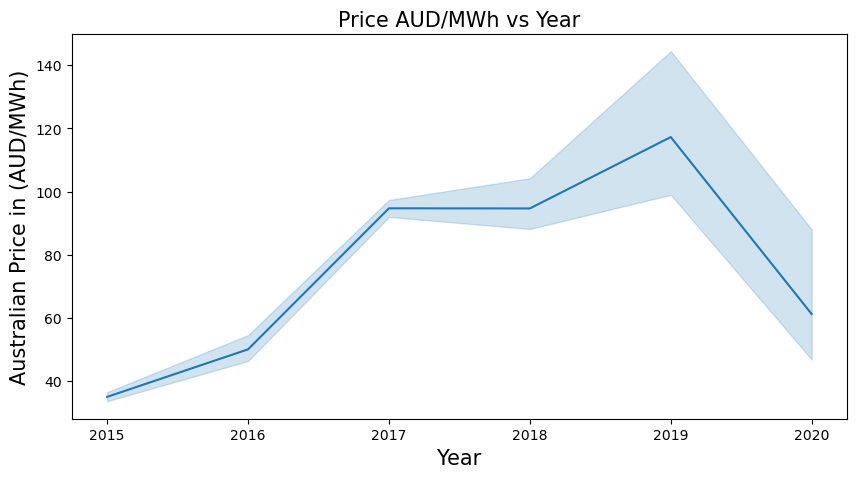

In [61]:
plt.figure(figsize=(10, 5))
g=sns.lineplot(data=df, x='Year', y='RRP')
g.set_ylabel('Australian Price in (AUD/MWh)', fontsize=15)
g.set_title('Price AUD/MWh vs Year', fontsize=15)
g.set_xlabel('Year', fontsize=15)
plt.show()

In [65]:
df = df_temp

## Detecting outliers and removing rows with z score value more than 5 and plotting before and after removing outliers

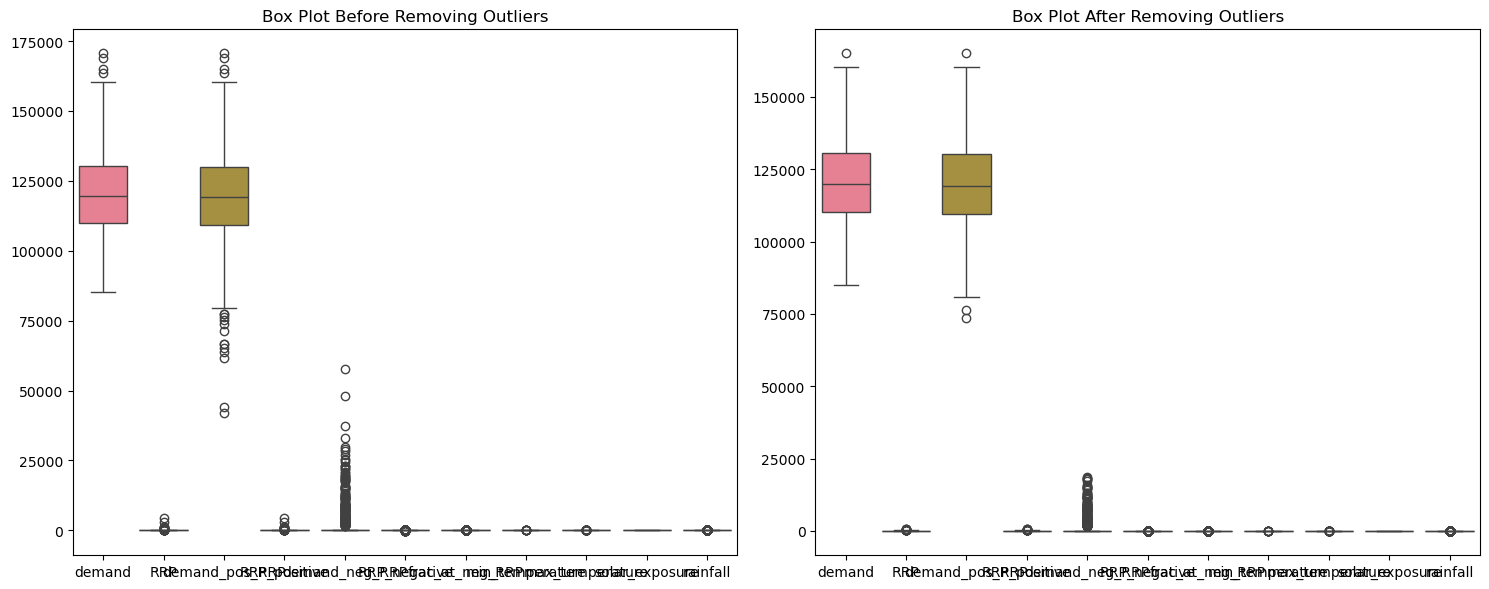

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot(data=df[numerical_cols], ax=axes[0])
axes[0].set_title('Box Plot Before Removing Outliers')

z_scores = np.abs(stats.zscore(df[numerical_cols]))

threshold = 5

outliers = np.where(z_scores > threshold)

df_no_outliers = df[(z_scores <= threshold).all(axis=1)]

sns.boxplot(data=df_no_outliers[numerical_cols], ax=axes[1])
axes[1].set_title('Box Plot After Removing Outliers')
plt.tight_layout()
plt.show()


## Label encoding school_day and holiday 

In [41]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['school_day'] = label_encoder.fit_transform(df['school_day'])

df['holiday'] = label_encoder.fit_transform(df['holiday'])

In [42]:
df.tail()

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
2101,2020-10-02,99585.835,-6.076028,41988.240,26.980251,57597.595,-30.173823,0.625000,12.8,26.0,22.0,0.0,0,0
2102,2020-10-03,92277.025,-1.983471,44133.510,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,0,0
2103,2020-10-04,94081.565,25.008614,88580.995,26.571687,5500.570,-0.163066,0.062500,13.5,29.5,8.4,0.0,0,0
2104,2020-10-05,113610.030,36.764701,106587.375,39.616015,7022.655,-6.511550,0.083333,9.1,12.7,7.3,12.8,0,0
2105,2020-10-06,122607.560,75.771059,122607.560,75.771059,0.000,0.000000,0.000000,8.9,12.6,5.8,1.0,0,0


## Scaling the data using min max scalar

In [43]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 5))

columns_to_scale = df.columns.difference(['date'])

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

## Converting date column to year, month and day attributes and dropping date column


In [44]:
df['date'] = pd.to_datetime(df['date'])

# Extracting year month and day from the date column
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

df = df.drop('date', axis=1)


In [45]:
## Rearranging dataframe columns for RRP to be the first column

df = df[['RRP', 'demand', 'demand_pos_RRP', 'RRP_positive', 'demand_neg_RRP', 'RRP_negative',
         'frac_at_neg_RRP', 'min_temperature', 'max_temperature', 'solar_exposure',
         'rainfall', 'school_day', 'holiday', 'year', 'month', 'day']]

In [46]:
df.head()

,RRP,demand,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,year,month,day
0,0.034802,0.849740,2.150186,0.014161,0.201032,4.894220,0.166667,2.317518,2.594203,3.512270,0.000000,0.0,5.0,2015,1,1
1,0.043039,2.601210,3.073618,0.027853,0.739961,4.301476,0.500000,2.700730,4.318841,4.003067,0.000000,0.0,0.0,2015,1,2
2,0.044604,3.343065,3.898179,0.023143,0.000000,5.000000,0.000000,3.540146,4.231884,3.957055,0.000000,0.0,0.0,2015,1,3
3,0.034113,1.124150,2.422655,0.012606,0.000000,5.000000,0.000000,2.864964,1.797101,3.757669,0.384615,0.0,0.0,2015,1,4
4,0.035999,1.930694,2.958987,0.014501,0.000000,5.000000,0.000000,2.627737,1.884058,4.601227,0.000000,0.0,0.0,2015,1,5


# Data organizing in S3 buckets
## Splitting train and test split with 80% train data, 10% as test and 10% as validationn and saving them to S3 buckets

In [117]:
import numpy as np
rand_split = np.random.rand(len(df)) 
train_list = rand_split < 0.8
val_list = (rand_split >= 0.8) & (rand_split < 0.9)
test_list = rand_split >= 0.9

s3 = boto3.resource('s3')
data_train = df[train_list]
data_train_csv = data_train.to_csv(index=False)
s3.Object(default_bucket, "train/train.csv").put(Body=data_train_csv)


data_val = df[val_list]
data_valid_csv = data_val.to_csv(index=False)
s3.Object(default_bucket, "validation/validation.csv").put(Body=data_valid_csv)


data_test = df[test_list]
data_test_csv = data_test.to_csv(index=False)
s3.Object(default_bucket, "test/test.csv").put(Body=data_test_csv)


{'ResponseMetadata': {'RequestId': 'G8CYF6ABM9SA7YJ0',
  'HostId': 'Ej8DZtEOLYdXuNuL8VLgVq/cOjGxYIHr/co9iMy6BL8Qjdj9bl5El6BLeCf2mRbYuNL2kIAm+bU=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'Ej8DZtEOLYdXuNuL8VLgVq/cOjGxYIHr/co9iMy6BL8Qjdj9bl5El6BLeCf2mRbYuNL2kIAm+bU=',
   'x-amz-request-id': 'G8CYF6ABM9SA7YJ0',
   'date': 'Thu, 23 Nov 2023 06:36:24 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"2c5b2b3087eb3d2da8ed1b259a8fd185"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"2c5b2b3087eb3d2da8ed1b259a8fd185"',
 'ServerSideEncryption': 'AES256'}

# Training
## defining xgboost container

In [294]:
from sagemaker import image_uris, model_uris, script_uris

container = "683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1"



In [119]:
import time
xgboost_job = "xgboost-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Job name is:", xgboost_job)



Job name is: xgboost-2023-11-23-06-38-49


In [120]:
train_data = "s3://mlpipeline-sid1/train/train.csv"
validation_data = "s3://mlpipeline-sid1/validation/validation.csv"

## Defining training params with train and validation data

In [121]:
xgboost_training_params = {
    "TrainingJobName": xgboost_job,
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File",
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": "s3://week7-output/output/",
    },
    "ResourceConfig": {
        "InstanceType": "ml.m4.xlarge",
        "InstanceCount": 1,
        "VolumeSizeInGB": 30,
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400,
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": train_data,
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "csv",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": validation_data,
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "ContentType": "csv",
        },
    ],
    "HyperParameters": {
        "objective": "reg:squarederror",
        "num_round": "100",
        "max_depth": "5"
    },
}


## Creating a training job for the xgboost model with the train data.

In [122]:
%%time

region = boto3.Session().region_name
sm = boto3.client("sagemaker")

sm.create_training_job(**xgboost_training_params)

status = sm.describe_training_job(TrainingJobName=xgboost_job)["TrainingJobStatus"]
print(status)
sm.get_waiter("training_job_completed_or_stopped").wait(TrainingJobName=xgboost_job)
if status == "Failed":
    message = sm.describe_training_job(TrainingJobName=xgboost_job)["FailureReason"]
    print("Training failed with the following error: {}".format(message))
    raise Exception("Training job failed")

InProgress
CPU times: user 138 ms, sys: 14.3 ms, total: 152 ms
Wall time: 4min


# Hosting
## Creating model for the above trained xgboost algorithm

In [123]:
xgboost_hosting_container = {
    "Image": container,
    "ModelDataUrl": sm.describe_training_job(TrainingJobName=xgboost_job)["ModelArtifacts"][
        "S3ModelArtifacts"
    ],
}

create_model_response = sm.create_model(
    ModelName=xgboost_job, ExecutionRoleArn=role, PrimaryContainer=xgboost_hosting_container
)

print(create_model_response["ModelArn"])

arn:aws:sagemaker:us-east-1:457756105170:model/xgboost-2023-11-23-06-38-49


## Defining endpoint configurations for the model to be deployed along with instance type 

In [124]:
xgboost_endpoint_config = "DEMO-xgboost-endpoint-config-" + time.strftime(
    "%Y-%m-%d-%H-%M-%S", time.gmtime()
)
print(xgboost_endpoint_config)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=xgboost_endpoint_config,
    ProductionVariants=[
        {
            "InstanceType": "ml.m4.xlarge",
            "InitialInstanceCount": 1,
            "ModelName": xgboost_job,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

DEMO-xgboost-endpoint-config-2023-11-23-06-44-58
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:457756105170:endpoint-config/demo-xgboost-endpoint-config-2023-11-23-06-44-58


## Deploying the endopoint for the trained xgboost model

In [125]:
xgboost_endpoint = "xgboost-endpoint-" + time.strftime("%Y%m%d%H%M", time.gmtime())
print(xgboost_endpoint)
create_endpoint_response = sm.create_endpoint(
    EndpointName=xgboost_endpoint, EndpointConfigName=xgboost_endpoint_config
)
print(create_endpoint_response["EndpointArn"])

resp = sm.describe_endpoint(EndpointName=xgboost_endpoint)
status = resp["EndpointStatus"]
print("Status: " + status)

sm.get_waiter("endpoint_in_service").wait(EndpointName=xgboost_endpoint)

resp = sm.describe_endpoint(EndpointName=xgboost_endpoint)
status = resp["EndpointStatus"]
print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

if status != "InService":
    raise Exception("Endpoint creation did not succeed")

DEMO-xgboost-endpoint-202311230645
arn:aws:sagemaker:us-east-1:457756105170:endpoint/demo-xgboost-endpoint-202311230645
Status: Creating
Arn: arn:aws:sagemaker:us-east-1:457756105170:endpoint/demo-xgboost-endpoint-202311230645
Status: InService


# Predicting


In [153]:
test_X = data_test.iloc[:,1:].to_csv(index=False, header=False)
test_y = data_test.iloc[:,0].to_csv(index=False, header=False)

## Invoking the created point to make predictions on the test dataset

In [154]:
%%time

runtime = boto3.client("sagemaker-runtime")

response = runtime.invoke_endpoint(
    EndpointName=xgboost_endpoint,
    ContentType="text/csv",
    Body=test_X.encode('utf-8')
)

response_body = response["Body"].read()

CPU times: user 33.8 ms, sys: 0 ns, total: 33.8 ms
Wall time: 107 ms


## Calculating accuracy metrics using the test set

In [159]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Actual data
actual_data = data_test.iloc[:, 0].values  

# Predicted data from the response
predicted_data_str = response_body.decode('utf-8')
predicted_data = np.array([float(val) for val in predicted_data_str.split('\n') if val])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_data, predicted_data)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_data, predicted_data)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')


MAE: 0.001970258560460822
MSE: 0.00037584436325163945
RMSE: 0.01938670583806438


## Plotting MAE, MSE and RMSE

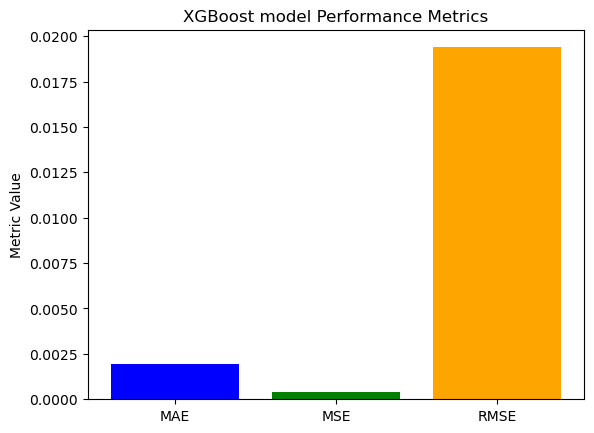

In [161]:
import matplotlib.pyplot as plt

# Plotting
metrics_names = ['MAE', 'MSE', 'RMSE']
metrics_values = [mae, mse, rmse]

plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'orange'])
plt.ylabel('Metric Value')
plt.title('XGBoost model Performance Metrics')
plt.show()


# Optimization
## Hyperparameter Optimization

In [318]:
from time import gmtime, strftime, sleep

tun_job_name = "xgb-tun" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print(tun_job_name)

xgb-tun2023-11-23-09-10-07


## Defining tuning job parameters and hyperparameters to be considered

In [319]:
tuning_job_config = {
    "ParameterRanges": {
        "CategoricalParameterRanges": [
        ],
        "ContinuousParameterRanges": [
            {
                "MaxValue": "1",
                "MinValue": "0",
                "Name": "eta",
            },
            {
                "MaxValue": "53",
                "MinValue": "1",
                "Name": "min_child_weight",
            },
            {
                "MaxValue": "250",
                "MinValue": "0",
                "Name": "alpha",
            },
            {
                "MaxValue": "1",
                "MinValue": "0.6",
                "Name": "subsample",
            },
        ],
        "IntegerParameterRanges": [
            {
                "MaxValue": "10",
                "MinValue": "2",
                "Name": "max_depth",
            },
            {
                "MaxValue": "1000",
                "MinValue": "25",
                "Name": "num_round",
            }
        ],
    },
    "ResourceLimits": {"MaxNumberOfTrainingJobs": 10, "MaxParallelTrainingJobs": 3},
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {"MetricName": "validation:mse", "Type": "Minimize"},
}

## Defining training job for the tuning job with eval metric as auc

In [320]:
from sagemaker.image_uris import retrieve

training_image = retrieve(framework="xgboost", region=region, version="1.7-1")

s3_input_train = "s3://{}/train/train.csv".format(default_bucket)
s3_input_validation = "s3://{}/validation/validation.csv".format(default_bucket)

training_job_definition = {
    "AlgorithmSpecification": {"TrainingImage": training_image, "TrainingInputMode": "File"},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_train,
                }
            },
        },
        {
            "ChannelName": "validation",
            "CompressionType": "None",
            "ContentType": "csv",
            "DataSource": {
                "S3DataSource": {
                    "S3DataDistributionType": "FullyReplicated",
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3_input_validation,
                }
            },
        },
    ],
    "OutputDataConfig": {"S3OutputPath": "s3://{}/output".format(default_bucket)},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.m4.xlarge", "VolumeSizeInGB": 10},
    "RoleArn": role,
    "StaticHyperParameters": {
        "objective": "reg:squarederror",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 43200},
}

## Starting the HPO job

In [321]:
client.create_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tun_job_name,
    HyperParameterTuningJobConfig=tuning_job_config,
    TrainingJobDefinition=training_job_definition,
)

{'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:457756105170:hyper-parameter-tuning-job/xgb-tun2023-11-23-09-10-07',
 'ResponseMetadata': {'RequestId': 'c5f66756-ebfa-49cd-9aa2-9a96ef5a2442',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c5f66756-ebfa-49cd-9aa2-9a96ef5a2442',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '127',
   'date': 'Thu, 23 Nov 2023 09:10:40 GMT'},
  'RetryAttempts': 0}}

## Checking the status of HPO job

In [323]:
client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tun_job_name)[
    "HyperParameterTuningJobStatus"
]

'Completed'

## Printing the list of all models with their parmeters 

In [324]:
from sagemaker.analytics import HyperparameterTuningJobAnalytics

In [325]:
import pandas as pd

tuner = HyperparameterTuningJobAnalytics(tun_job_name)

full_df = tuner.dataframe()

if len(full_df) > 0:
    df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df) > 0:
        df = df.sort_values("FinalObjectiveValue", ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest": min(df["FinalObjectiveValue"]), "highest": max(df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", None)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

full_df

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Number of training jobs with valid objective: 10
{'lowest': 0.00215000007301569, 'highest': 0.034699998795986176}


,alpha,eta,max_depth,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,19.279175,0.113070,6.0,22.789492,613.0,0.773005,xgb-tun2023-11-23-09-10-07-010-73b6b1d6,Completed,0.00215,2023-11-23 09:16:31+00:00,2023-11-23 09:17:08+00:00,37.0
1,0.000000,0.605104,5.0,53.000000,194.0,1.000000,xgb-tun2023-11-23-09-10-07-009-909d19eb,Completed,0.00437,2023-11-23 09:16:29+00:00,2023-11-23 09:17:01+00:00,32.0
2,82.044614,0.990737,3.0,21.653845,311.0,0.765038,xgb-tun2023-11-23-09-10-07-008-56c7a30d,Completed,0.00683,2023-11-23 09:15:45+00:00,2023-11-23 09:16:27+00:00,42.0
3,26.177276,0.524912,7.0,22.346308,564.0,0.744045,xgb-tun2023-11-23-09-10-07-007-89f5b867,Completed,0.00260,2023-11-23 09:15:34+00:00,2023-11-23 09:16:11+00:00,37.0
4,174.356153,0.376643,5.0,22.811113,477.0,0.704446,xgb-tun2023-11-23-09-10-07-006-e473f1d2,Completed,0.02451,2023-11-23 09:15:33+00:00,2023-11-23 09:16:10+00:00,37.0
5,128.748294,0.627166,9.0,29.895597,65.0,0.605507,xgb-tun2023-11-23-09-10-07-005-adce4436,Completed,0.01898,2023-11-23 09:14:48+00:00,2023-11-23 09:15:25+00:00,37.0
6,89.071695,0.083588,8.0,22.215055,423.0,0.714692,xgb-tun2023-11-23-09-10-07-004-826ff805,Completed,0.00856,2023-11-23 09:14:41+00:00,2023-11-23 09:15:18+00:00,37.0
7,188.442196,0.302182,8.0,43.681616,531.0,0.630335,xgb-tun2023-11-23-09-10-07-003-d145a9be,Completed,0.03470,2023-11-23 09:12:48+00:00,2023-11-23 09:14:40+00:00,112.0
8,140.316306,0.684837,7.0,26.185962,52.0,0.827705,xgb-tun2023-11-23-09-10-07-002-a943d28f,Completed,0.01283,2023-11-23 09:12:43+00:00,2023-11-23 09:14:25+00:00,102.0
9,139.801250,0.864528,9.0,12.687480,763.0,0.702473,xgb-tun2023-11-23-09-10-07-001-803ece45,Completed,0.01713,2023-11-23 09:13:26+00:00,2023-11-23 09:15:13+00:00,107.0


## Selecting the best model from the HPO job and printing its details 

In [326]:
from pprint import pprint

tuning_job_result = client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tun_job_name
)

if tuning_job_result.get("BestTrainingJob", None):
    print("Best model found so far:")
    pprint(tuning_job_result["BestTrainingJob"])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2023, 11, 23, 9, 16, 27, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mse',
                                                 'Value': 0.00215000007301569},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2023, 11, 23, 9, 17, 8, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:457756105170:training-job/xgb-tun2023-11-23-09-10-07-010-73b6b1d6',
 'TrainingJobName': 'xgb-tun2023-11-23-09-10-07-010-73b6b1d6',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2023, 11, 23, 9, 16, 31, tzinfo=tzlocal()),
 'TunedHyperParameters': {'alpha': '19.27917461236256',
                          'eta': '0.11307039788259454',
                          'max_depth': '6',
                          'min_child_weight': '22.789492011548198',
                          'num_round': '613',
                          'subsample': '0.77300526684

## Deploying the best model chosen from the HPO job

In [327]:
xgb_best_model = tuning_job_result.get("BestTrainingJob", None)
model_name = 'xgb-best-model1'

xgboost_hosting_container = {
    "Image": container,
    "ModelDataUrl": sm.describe_training_job(TrainingJobName=xgb_best_model['TrainingJobName'])["ModelArtifacts"][
        "S3ModelArtifacts"
    ],
}

create_model_response = sm.create_model(
    ModelName=model_name, ExecutionRoleArn=role, PrimaryContainer=xgboost_hosting_container
)

print(create_model_response["ModelArn"])

arn:aws:sagemaker:us-east-1:457756105170:model/xgb-best-model1


In [328]:
xgboost_endpoint_config = "xgboost-best-endpoint-" + time.strftime(
    "%Y-%m-%d-%H-%M-%S", time.gmtime()
)
print(xgboost_endpoint_config)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=xgboost_endpoint_config,
    ProductionVariants=[
        {
            "InstanceType": "ml.m4.xlarge",
            "InitialInstanceCount": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

xgboost-best-endpoint-2023-11-23-09-18-37
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:457756105170:endpoint-config/xgboost-best-endpoint-2023-11-23-09-18-37


In [329]:
xgboost_endpoint = "xgboost-best-endpt-" + time.strftime("%Y%m%d%H%M", time.gmtime())
print(xgboost_endpoint)
create_endpoint_response = sm.create_endpoint(
    EndpointName=xgboost_endpoint, EndpointConfigName=xgboost_endpoint_config
)
print(create_endpoint_response["EndpointArn"])

resp = sm.describe_endpoint(EndpointName=xgboost_endpoint)
status = resp["EndpointStatus"]
print("Status: " + status)

sm.get_waiter("endpoint_in_service").wait(EndpointName=xgboost_endpoint)

resp = sm.describe_endpoint(EndpointName=xgboost_endpoint)
status = resp["EndpointStatus"]
print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

if status != "InService":
    raise Exception("Endpoint creation did not succeed")

xgboost-best-endpt-202311230918
arn:aws:sagemaker:us-east-1:457756105170:endpoint/xgboost-best-endpt-202311230918
Status: Creating
Arn: arn:aws:sagemaker:us-east-1:457756105170:endpoint/xgboost-best-endpt-202311230918
Status: InService


## Using the best deployed model to make prediction

In [330]:
test_X = data_test.iloc[:,1:].to_csv(index=False, header=False)
test_y = data_test.iloc[:,0].to_csv(index=False, header=False)

In [331]:
%%time

runtime = boto3.client("sagemaker-runtime")

response = runtime.invoke_endpoint(
    EndpointName=xgboost_endpoint,
    ContentType="text/csv",
    Body=test_X.encode('utf-8')
)

response_body = response["Body"].read()

CPU times: user 35.4 ms, sys: 101 µs, total: 35.5 ms
Wall time: 155 ms


## Measuring the performance metrics of the best deployed Xgboost model

In [332]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Actual data
actual_data = data_test.iloc[:, 0].values  

# Predicted data from the response
predicted_data_str = response_body.decode('utf-8')
predicted_data = np.array([float(val) for val in predicted_data_str.split('\n') if val])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actual_data, predicted_data)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(actual_data, predicted_data)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')


MAE: 0.02279733735755633
MSE: 0.004205050165484049
RMSE: 0.06484635815127977
